In [2]:
from typing import List, Tuple
import time
import numpy as np

from gurobi_server import run_generic_model

N_WORKERS_EXPONENTIAL_DISTR_LAMBDA = 17
WORKER_LOAD_EXPONENTIAL_DISTR_LAMBDA = 0.7
HOST_CAPACITY = 1.0

class Host:
    def __init__(self, name: str, cap: float):
        self.name: str = name
        self.cap: str = cap
        self.worker_ids: List[int] = []
        
    def __str__(self):
        return f"{self.name}: cap={self.cap}, n_workers={len(self.worker_ids)}"
        
class Tenant:
    def __init__(self, name: str, load: float, fshare: float = 0.0):
        self.name: str = name
        self.load: float = load
        self.fshareload: float = fshare
        
    def __str__(self):
        return f"{self.name}: load={self.load}, fshareload={self.fshareload}"

class Worker:
    def __init__(self, name: str, tenant: str, host: str, tenant_id: int = -1):
        self.name: str = name
        self.tenant: str = tenant
        self.tenant_id: int = tenant_id
        self.host: str = host
        
    def __str__(self):
        return f"{self.name}: tenant={self.tenant}, host={self.host}"

def get_topology(n_hosts: int) -> Tuple[List[Host], List[Tenant], List[Worker]]:
    
    print(f"number of hosts: {n_hosts}")
    
    n_tenants = int(n_hosts * 0.65)
    print(f"number of tenants: {n_tenants}")    
    
    n_workers_per_ms = list(map(int, np.random.exponential(
        N_WORKERS_EXPONENTIAL_DISTR_LAMBDA, size=n_tenants)))
    print(f"number of workers: {np.sum(n_workers_per_ms)}")
    
    hosts = [Host(f"host{i}", 1.0) for i in range(n_hosts)]
    
    tenants = []
    workers = []
    worker_id = 0
    for i in range(n_tenants):
        
        tenant_load = np.sum(np.random.exponential(
            WORKER_LOAD_EXPONENTIAL_DISTR_LAMBDA, size=n_workers_per_ms[i]))
        
        tenant = Tenant(f"tenant{i}", tenant_load)
        tenants.append(tenant)
        
        for j in range(n_workers_per_ms[i]):
            
            host_idx = np.random.randint(0, n_hosts)
            host_name = f"host{host_idx}"
            
            worker = Worker(f"tenant{i}_{j}", tenant.name, host_name, i)
            workers.append(worker)
            
            hosts[host_idx].worker_ids.append(worker_id)
            
            worker_id += 1
    
    for host in hosts:
        
        fshare_of_each_worker = HOST_CAPACITY / len(host.worker_ids) if len(host.worker_ids) > 0 else 0.0
        
        for worker_id in host.worker_ids:
            worker = workers[worker_id]
            tenant = tenants[worker.tenant_id]
            tenant.fshareload += fshare_of_each_worker
    
    # print("Hosts:")
    # for host in hosts:
    #     print(host)
    
    # print("Tenants:")
    # for tenant in tenants:
    #     print(tenant)
        
    # print("Workers:")
    # for worker in workers:
    #     print(worker)
    
    return hosts, tenants, workers

In [4]:
import pandas as pd

def run_scale_experiment(n_hosts):
    
    data = []
    
    for n_hosts in n_hosts: #, 125, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]:
        hosts, tenants, workers = get_topology(n_hosts)
        
        start_time = time.time()
        run_generic_model(hosts, tenants, workers)
        time_taken = time.time() - start_time
        
        print(f"Time taken for {n_hosts} hosts: {time_taken*1000:.2f}ms")
        
        data.append([n_hosts, len(tenants), len(workers), time_taken*1000])
        
    return data
    
df = pd.DataFrame(columns=['n_hosts', 'n_tenants', 'n_workers', 'time_taken'])

# df = pd.concat([df, pd.DataFrame(run_scale_experiment(), columns=['n_hosts', 'time_taken'])])
# df

In [10]:
for _ in range(2):
    n_hosts = [3, 5, 10, 25, 50, 100, 200, 400]
    df = pd.concat([df, pd.DataFrame(run_scale_experiment(n_hosts), columns=['n_hosts', 'n_tenants', 'n_workers', 'time_taken'])])
    df

number of hosts: 3
number of tenants: 1
number of workers: 16
{'tenant0_0': <gurobi.Var *Awaiting Model Update*>, 'tenant0_1': <gurobi.Var *Awaiting Model Update*>, 'tenant0_2': <gurobi.Var *Awaiting Model Update*>, 'tenant0_3': <gurobi.Var *Awaiting Model Update*>, 'tenant0_4': <gurobi.Var *Awaiting Model Update*>, 'tenant0_5': <gurobi.Var *Awaiting Model Update*>, 'tenant0_6': <gurobi.Var *Awaiting Model Update*>, 'tenant0_7': <gurobi.Var *Awaiting Model Update*>, 'tenant0_8': <gurobi.Var *Awaiting Model Update*>, 'tenant0_9': <gurobi.Var *Awaiting Model Update*>, 'tenant0_10': <gurobi.Var *Awaiting Model Update*>, 'tenant0_11': <gurobi.Var *Awaiting Model Update*>, 'tenant0_12': <gurobi.Var *Awaiting Model Update*>, 'tenant0_13': <gurobi.Var *Awaiting Model Update*>, 'tenant0_14': <gurobi.Var *Awaiting Model Update*>, 'tenant0_15': <gurobi.Var *Awaiting Model Update*>}
tenant0: (lb: 3.0000000000000013, ub: 9.90136552586981)
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 -

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 5 rows, 24 columns and 39 nonzeros


INFO:gurobipy:Optimize a model with 5 rows, 24 columns and 39 nonzeros


Model fingerprint: 0x2fa79e27


INFO:gurobipy:Model fingerprint: 0x2fa79e27


Model has 1 general constraint


INFO:gurobipy:Model has 1 general constraint


Variable types: 24 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 24 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+01]


INFO:gurobipy:  Bounds range     [1e+00, 1e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve removed 5 rows and 24 columns


INFO:gurobipy:Presolve removed 5 rows and 24 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)


Thread count was 1 (of 32 available processors)


INFO:gurobipy:Thread count was 1 (of 32 available processors)


INFO:gurobipy:


Solution count 1: -23.0259 


INFO:gurobipy:Solution count 1: -23.0259 


No other solutions better than -23.0259


INFO:gurobipy:No other solutions better than -23.0259


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


INFO:gurobipy:Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'w_tenant0_0': 0.0, 'w_tenant0_1': 0.0, 'w_tenant0_2': 1.0, 'w_tenant0_3': 0.0, 'w_tenant0_4': 0.0, 'w_tenant0_5': 0.0, 'w_tenant0_6': 0.0, 'w_tenant0_7': 0.0, 'w_tenant0_8': 0.0, 'w_tenant0_9': 0.0, 'w_tenant0_10': 1.0, 'w_tenant0_11': 0.0, 'w_tenant0_12': 0.0, 'w_tenant0_13': 0.0, 'w_tenant0_14': 1.0, 'w_tenant0_15': 0.0, 't_min_tenant0': 3.0, 't_consumed_tenant0': 3.0, 't_excess_consumed_tenant0': 0.0, 't_log_excess_consumed_tenant0': -23.025850929940457, 'one': 1.0}
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 9 rows, 28 columns and 63 nonzeros


INFO:gurobipy:Optimize a model with 9 rows, 28 columns and 63 nonzeros


Model fingerprint: 0x32fc113d


INFO:gurobipy:Model fingerprint: 0x32fc113d


Model has 6 quadratic objective terms


INFO:gurobipy:Model has 6 quadratic objective terms


Model has 1 general constraint


INFO:gurobipy:Model has 1 general constraint


Variable types: 28 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 28 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [0e+00, 0e+00]


INFO:gurobipy:  Objective range  [0e+00, 0e+00]


  QObjective range [4e-01, 4e-01]


INFO:gurobipy:  QObjective range [4e-01, 4e-01]


  Bounds range     [1e+00, 1e+01]


INFO:gurobipy:  Bounds range     [1e+00, 1e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


INFO:gurobipy:


MIP start from previous solve produced solution with objective 0 (0.03s)


INFO:gurobipy:MIP start from previous solve produced solution with objective 0 (0.03s)


Loaded MIP start from previous solve with objective 0


INFO:gurobipy:Loaded MIP start from previous solve with objective 0


INFO:gurobipy:


Presolve removed 9 rows and 28 columns


INFO:gurobipy:Presolve removed 9 rows and 28 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 1 (of 32 available processors)


INFO:gurobipy:Thread count was 1 (of 32 available processors)


INFO:gurobipy:


Solution count 2: 0 0 


INFO:gurobipy:Solution count 2: 0 0 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'w_tenant0_0': 0.0, 'w_tenant0_1': 0.0, 'w_tenant0_2': 1.0, 'w_tenant0_3': 0.0, 'w_tenant0_4': 0.0, 'w_tenant0_5': 0.0, 'w_tenant0_6': 0.0, 'w_tenant0_7': 0.0, 'w_tenant0_8': 0.0, 'w_tenant0_9': 0.0, 'w_tenant0_10': 1.0, 'w_tenant0_11': 0.0, 'w_tenant0_12': 0.0, 'w_tenant0_13': 0.0, 'w_tenant0_14': 1.0, 'w_tenant0_15': 0.0, 't_min_tenant0': 3.0, 't_consumed_tenant0': 3.0, 't_excess_consumed_tenant0': 0.0, 't_log_excess_consumed_tenant0': -23.025850929940457, 'one': 1.0, 't_consumed_min_tenant0': 3.0, 'sp_host0': 0.0, 'sp_host1': 0.0, 'sp_host2': 0.0}
{'status': 2, 'result': {'tenant0': {'tenant0_0': 0.0, 'tenant0_1': 0.0, 'tenant0_2': 1.0, 'tenant0_3': 0.0, 'tenant0_4': 0.0, 'tenant0_5': 0.0, 'tenant0_6': 0.0, 'tenant0_7': 0.0, 'tenant0_8': 0.0, 'tenant0_9': 0.0, 'tenant0_10': 1.0, 'tenant0_11': 0.0, 'tenant0_12': 0.0, 'tenant0_13': 0.0, 'tenant0_14': 1.0, 'tenant0_15': 0.0}}}
Time taken for 3 hosts: 176.08ms
number of hosts: 5
num

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 11 rows, 47 columns and 75 nonzeros


INFO:gurobipy:Optimize a model with 11 rows, 47 columns and 75 nonzeros


Model fingerprint: 0xe35617af


INFO:gurobipy:Model fingerprint: 0xe35617af


Model has 3 general constraints


INFO:gurobipy:Model has 3 general constraints


Variable types: 47 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 47 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e-01, 4e-01]


INFO:gurobipy:  Objective range  [3e-01, 4e-01]


  Bounds range     [1e+00, 1e+01]


INFO:gurobipy:  Bounds range     [1e+00, 1e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 37 rows and 171 columns


INFO:gurobipy:Presolve added 37 rows and 171 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 218 columns, 2501 nonzeros


INFO:gurobipy:Presolved: 48 rows, 218 columns, 2501 nonzeros


Variable types: 200 continuous, 18 integer (3 binary)


INFO:gurobipy:Variable types: 200 continuous, 18 integer (3 binary)


Found heuristic solution: objective -23.0258509


INFO:gurobipy:Found heuristic solution: objective -23.0258509


INFO:gurobipy:


Root relaxation: cutoff, 94 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: cutoff, 94 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0     cutoff    0       -23.02585  -23.02585  0.00%     -    0s


INFO:gurobipy:     0     0     cutoff    0       -23.02585  -23.02585  0.00%     -    0s


INFO:gurobipy:


Explored 1 nodes (94 simplex iterations) in 0.06 seconds (0.01 work units)


INFO:gurobipy:Explored 1 nodes (94 simplex iterations) in 0.06 seconds (0.01 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: -23.0259 


INFO:gurobipy:Solution count 1: -23.0259 


No other solutions better than -23.0259


INFO:gurobipy:No other solutions better than -23.0259


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


INFO:gurobipy:Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'w_tenant0_0': 0.0, 'w_tenant0_1': 0.0, 'w_tenant0_2': 0.0, 'w_tenant0_3': 1.0, 'w_tenant0_4': 0.3314814814814815, 'w_tenant0_5': 0.0, 'w_tenant0_6': 0.3314814814814815, 'w_tenant0_7': 0.3314814814814815, 'w_tenant0_8': 0.0, 'w_tenant0_9': 0.0, 'w_tenant0_10': 0.0, 'w_tenant1_0': 1.0, 'w_tenant1_1': 0.0, 'w_tenant1_2': 0.0, 'w_tenant1_3': 0.0981481481481481, 'w_tenant1_4': 0.0981481481481481, 'w_tenant1_5': 0.0, 'w_tenant1_6': 0.0981481481481481, 'w_tenant2_0': 0.0, 'w_tenant2_1': 0.0, 'w_tenant2_2': 0.0, 'w_tenant2_3': 0.5703703703703704, 'w_tenant2_4': 0.0, 'w_tenant2_5': 0.0, 'w_tenant2_6': 0.0, 'w_tenant2_7': 0.5703703703703704, 'w_tenant2_8': 0.0, 'w_tenant2_9': 0.0, 'w_tenant2_10': 0.5703703703703704, 't_min_tenant0': 1.9944444444444445, 't_min_tenant1': 1.2944444444444445, 't_min_tenant2': 1.711111111111111, 't_consumed_tenant0': 1.9944444444444445, 't_consumed_tenant1': 1.2944444444444445

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 19 rows, 55 columns and 120 nonzeros


INFO:gurobipy:Optimize a model with 19 rows, 55 columns and 120 nonzeros


Model fingerprint: 0xa1089321


INFO:gurobipy:Model fingerprint: 0xa1089321


Model has 15 quadratic objective terms


INFO:gurobipy:Model has 15 quadratic objective terms


Model has 3 general constraints


INFO:gurobipy:Model has 3 general constraints


Variable types: 55 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 55 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [0e+00, 0e+00]


INFO:gurobipy:  Objective range  [0e+00, 0e+00]


  QObjective range [2e-01, 3e-01]


INFO:gurobipy:  QObjective range [2e-01, 3e-01]


  Bounds range     [1e+00, 1e+01]


INFO:gurobipy:  Bounds range     [1e+00, 1e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


INFO:gurobipy:


MIP start from previous solve produced solution with objective 0 (0.04s)


INFO:gurobipy:MIP start from previous solve produced solution with objective 0 (0.04s)


Loaded MIP start from previous solve with objective 0


INFO:gurobipy:Loaded MIP start from previous solve with objective 0


INFO:gurobipy:


Presolve added 32 rows and 175 columns


INFO:gurobipy:Presolve added 32 rows and 175 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 51 rows, 230 columns, 2520 nonzeros


INFO:gurobipy:Presolved: 51 rows, 230 columns, 2520 nonzeros


Presolved model has 15 quadratic objective terms


INFO:gurobipy:Presolved model has 15 quadratic objective terms


Variable types: 212 continuous, 18 integer (3 binary)


INFO:gurobipy:Variable types: 212 continuous, 18 integer (3 binary)


INFO:gurobipy:


Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


Explored 1 nodes (0 simplex iterations) in 0.07 seconds (0.01 work units)


INFO:gurobipy:Explored 1 nodes (0 simplex iterations) in 0.07 seconds (0.01 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: 0 


INFO:gurobipy:Solution count 1: 0 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'w_tenant0_0': 0.0, 'w_tenant0_1': 0.0, 'w_tenant0_2': 1.0, 'w_tenant0_3': 0.0, 'w_tenant0_4': 0.0, 'w_tenant0_5': 0.9944444444444445, 'w_tenant0_6': 0.0, 'w_tenant0_7': 0.0, 'w_tenant0_8': 0.0, 'w_tenant0_9': 0.0, 'w_tenant0_10': 0.0, 'w_tenant1_0': 0.0, 'w_tenant1_1': 0.0, 'w_tenant1_2': 0.28888888888888886, 'w_tenant1_3': 0.0, 'w_tenant1_4': 0.0, 'w_tenant1_5': 0.005555555555555556, 'w_tenant1_6': 1.0, 'w_tenant2_0': 0.0, 'w_tenant2_1': 0.0, 'w_tenant2_2': 0.0, 'w_tenant2_3': 1.0, 'w_tenant2_4': 0.7111111111111111, 'w_tenant2_5': 0.0, 'w_tenant2_6': 0.0, 'w_tenant2_7': 0.0, 'w_tenant2_8': 0.0, 'w_tenant2_9': 0.0, 'w_tenant2_10': 0.0, 't_min_tenant0': 1.9944444444444445, 't_min_tenant1': 1.2944444444444445, 't_min_tenant2': 1.711111111111111, 't_consumed_tenant0': 1.9944444444444445, 't_consumed_tenant1': 1.2944444444444445, 't_consumed_tenant2': 1.711111111111111, 't_excess_consumed_tenant0': 

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 22 rows, 246 columns and 456 nonzeros


INFO:gurobipy:Optimize a model with 22 rows, 246 columns and 456 nonzeros


Model fingerprint: 0xf1063f4a


INFO:gurobipy:Model fingerprint: 0xf1063f4a


Model has 6 general constraints


INFO:gurobipy:Model has 6 general constraints


Variable types: 246 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 246 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 5e-01]


INFO:gurobipy:  Objective range  [4e-02, 5e-01]


  Bounds range     [4e-01, 7e+01]


INFO:gurobipy:  Bounds range     [4e-01, 7e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 81 rows and 243 columns


INFO:gurobipy:Presolve added 81 rows and 243 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 103 rows, 489 columns, 5662 nonzeros


INFO:gurobipy:Presolved: 103 rows, 489 columns, 5662 nonzeros


Variable types: 449 continuous, 40 integer (10 binary)


INFO:gurobipy:Variable types: 449 continuous, 40 integer (10 binary)


Found heuristic solution: objective -23.0258509


INFO:gurobipy:Found heuristic solution: objective -23.0258509


INFO:gurobipy:


Root relaxation: cutoff, 191 iterations, 0.01 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: cutoff, 191 iterations, 0.01 seconds (0.00 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0     cutoff    0       -23.02585  -23.02585  0.00%     -    0s


INFO:gurobipy:     0     0     cutoff    0       -23.02585  -23.02585  0.00%     -    0s


INFO:gurobipy:


Explored 1 nodes (191 simplex iterations) in 0.08 seconds (0.01 work units)


INFO:gurobipy:Explored 1 nodes (191 simplex iterations) in 0.08 seconds (0.01 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: -23.0259 


INFO:gurobipy:Solution count 1: -23.0259 


No other solutions better than -23.0259


INFO:gurobipy:No other solutions better than -23.0259


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


INFO:gurobipy:Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'cap_host5': 1.0, 'cap_host6': 1.0, 'cap_host7': 1.0, 'cap_host8': 1.0, 'cap_host9': 1.0, 'w_tenant0_0': 0.0, 'w_tenant0_1': 0.0, 'w_tenant0_2': 0.0, 'w_tenant0_3': 0.0, 'w_tenant0_4': 0.0, 'w_tenant0_5': 0.0, 'w_tenant0_6': 0.0, 'w_tenant0_7': 0.0, 'w_tenant0_8': 0.3553321678321678, 'w_tenant1_0': 0.0, 'w_tenant1_1': 0.0, 'w_tenant1_2': 0.0, 'w_tenant1_3': 0.0, 'w_tenant1_4': 0.0, 'w_tenant1_5': 0.0, 'w_tenant1_6': 0.0, 'w_tenant1_7': 0.0, 'w_tenant1_8': 0.0, 'w_tenant1_9': 0.0, 'w_tenant1_10': 0.0, 'w_tenant1_11': 0.0, 'w_tenant1_12': 0.3519735819735819, 'w_tenant1_13': 0.0, 'w_tenant1_14': 0.3519735819735819, 'w_tenant2_0': 0.0, 'w_tenant2_1': 0.2512962962962962, 'w_tenant2_2': 0.0, 'w_tenant2_3': 0.0, 'w_tenant2_4': 0.0, 'w_tenant2_5': 0.0, 'w_tenant2_6': 0.0, 'w_tenant2_7': 0.0, 'w_tenant2_8': 0.0, 'w_tenant2_9': 0.0, 'w_tenant2_10': 0.0, 'w_tenant2_11': 0.0, 'w_tenant2_12': 0.0, 'w_tenant2_

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 38 rows, 262 columns and 699 nonzeros


INFO:gurobipy:Optimize a model with 38 rows, 262 columns and 699 nonzeros


Model fingerprint: 0xde248f43


INFO:gurobipy:Model fingerprint: 0xde248f43


Model has 55 quadratic objective terms


INFO:gurobipy:Model has 55 quadratic objective terms


Model has 6 general constraints


INFO:gurobipy:Model has 6 general constraints


Variable types: 262 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 262 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [0e+00, 0e+00]


INFO:gurobipy:  Objective range  [0e+00, 0e+00]


  QObjective range [4e-02, 2e-01]


INFO:gurobipy:  QObjective range [4e-02, 2e-01]


  Bounds range     [4e-01, 7e+01]


INFO:gurobipy:  Bounds range     [4e-01, 7e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


INFO:gurobipy:


MIP start from previous solve produced solution with objective 0 (0.04s)


INFO:gurobipy:MIP start from previous solve produced solution with objective 0 (0.04s)


Loaded MIP start from previous solve with objective 0


INFO:gurobipy:Loaded MIP start from previous solve with objective 0


INFO:gurobipy:


Presolve added 70 rows and 262 columns


INFO:gurobipy:Presolve added 70 rows and 262 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 108 rows, 524 columns, 5722 nonzeros


INFO:gurobipy:Presolved: 108 rows, 524 columns, 5722 nonzeros


Presolved model has 55 quadratic objective terms


INFO:gurobipy:Presolved model has 55 quadratic objective terms


Variable types: 484 continuous, 40 integer (10 binary)


INFO:gurobipy:Variable types: 484 continuous, 40 integer (10 binary)


INFO:gurobipy:


Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


Explored 1 nodes (0 simplex iterations) in 0.10 seconds (0.03 work units)


INFO:gurobipy:Explored 1 nodes (0 simplex iterations) in 0.10 seconds (0.03 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: 0 


INFO:gurobipy:Solution count 1: 0 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'cap_host5': 1.0, 'cap_host6': 1.0, 'cap_host7': 1.0, 'cap_host8': 1.0, 'cap_host9': 1.0, 'w_tenant0_0': 0.0, 'w_tenant0_1': 0.0, 'w_tenant0_2': 0.0, 'w_tenant0_3': 0.0, 'w_tenant0_4': 0.35533216783216726, 'w_tenant0_5': 0.0, 'w_tenant0_6': 0.0, 'w_tenant0_7': 0.0, 'w_tenant0_8': 0.0, 'w_tenant1_0': 0.0, 'w_tenant1_1': 0.0, 'w_tenant1_2': 0.0, 'w_tenant1_3': 0.0, 'w_tenant1_4': 0.0, 'w_tenant1_5': 0.0, 'w_tenant1_6': 0.0, 'w_tenant1_7': 0.0, 'w_tenant1_8': 0.0, 'w_tenant1_9': 0.0, 'w_tenant1_10': 0.0, 'w_tenant1_11': 0.0, 'w_tenant1_12': 0.7039471639471638, 'w_tenant1_13': 0.0, 'w_tenant1_14': 0.0, 'w_tenant2_0': 0.0, 'w_tenant2_1': 1.0, 'w_tenant2_2': 0.0, 'w_tenant2_3': 0.0, 'w_tenant2_4': 0.0, 'w_tenant2_5': 0.0, 'w_tenant2_6': 0.0, 'w_tenant2_7': 0.0, 'w_tenant2_8': 0.0, 'w_tenant2_9': 0.0, 'w_tenant2_10': 0.0, 'w_tenant2_11': 0.0, 'w_tenant2_12': 0.0, 'w_tenant2_13': 0.0, 'w_tenant2_14': 0.0

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 57 rows, 382 columns and 673 nonzeros


INFO:gurobipy:Optimize a model with 57 rows, 382 columns and 673 nonzeros


Model fingerprint: 0x70a4ceae


INFO:gurobipy:Model fingerprint: 0x70a4ceae


Model has 16 general constraints


INFO:gurobipy:Model has 16 general constraints


Variable types: 382 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 382 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-03, 2e-01]


INFO:gurobipy:  Objective range  [4e-03, 2e-01]


  Bounds range     [1e-01, 5e+01]


INFO:gurobipy:  Bounds range     [1e-01, 5e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 23 rows and 774 columns


INFO:gurobipy:Presolve added 23 rows and 774 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 80 rows, 1156 columns, 3240 nonzeros


INFO:gurobipy:Presolved: 80 rows, 1156 columns, 3240 nonzeros


Presolved model has 15 SOS constraint(s)


INFO:gurobipy:Presolved model has 15 SOS constraint(s)


Variable types: 1156 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 1156 continuous, 0 integer (0 binary)


INFO:gurobipy:


Root relaxation: objective -2.302585e+01, 466 iterations, 0.01 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: objective -2.302585e+01, 466 iterations, 0.01 seconds (0.00 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0     -23.0258512  -23.02585  0.00%     -    0s


INFO:gurobipy:*    0     0               0     -23.0258512  -23.02585  0.00%     -    0s


INFO:gurobipy:


Explored 1 nodes (466 simplex iterations) in 0.07 seconds (0.01 work units)


INFO:gurobipy:Explored 1 nodes (466 simplex iterations) in 0.07 seconds (0.01 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: -23.0259 


INFO:gurobipy:Solution count 1: -23.0259 


No other solutions better than -23.0259


INFO:gurobipy:No other solutions better than -23.0259


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective -2.302585115887e+01, best bound -2.302585115887e+01, gap 0.0000%


INFO:gurobipy:Best objective -2.302585115887e+01, best bound -2.302585115887e+01, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'cap_host5': 1.0, 'cap_host6': 1.0, 'cap_host7': 1.0, 'cap_host8': 1.0, 'cap_host9': 1.0, 'cap_host10': 1.0, 'cap_host11': 1.0, 'cap_host12': 1.0, 'cap_host13': 1.0, 'cap_host14': 1.0, 'cap_host15': 1.0, 'cap_host16': 1.0, 'cap_host17': 1.0, 'cap_host18': 1.0, 'cap_host19': 1.0, 'cap_host20': 1.0, 'cap_host21': 1.0, 'cap_host22': 1.0, 'cap_host23': 1.0, 'cap_host24': 1.0, 'w_tenant0_0': 0.1, 'w_tenant1_0': 0.0, 'w_tenant1_1': 0.9148164699796313, 'w_tenant1_2': 0.0, 'w_tenant1_3': 0.0, 'w_tenant1_4': 0.0, 'w_tenant1_5': 0.0, 'w_tenant1_6': 0.0, 'w_tenant1_7': 0.0, 'w_tenant1_8': 0.0, 'w_tenant1_9': 0.0, 'w_tenant1_10': 0.0, 'w_tenant1_11': 0.0, 'w_tenant1_12': 0.0, 'w_tenant1_13': 0.0, 'w_tenant1_14': 0.0, 'w_tenant1_15': 0.0, 'w_tenant1_16': 0.0, 'w_tenant1_17': 0.0, 'w_tenant1_18': 1.0, 'w_tenant1_19': 0.0, 'w_tenant1_20': 0.0, 'w_tenant1_21': 0.0, 'w_tenant1_22': 0.0, 'w_tenant1_23': 0.0, 'w_te

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 98 rows, 423 columns and 1047 nonzeros


INFO:gurobipy:Optimize a model with 98 rows, 423 columns and 1047 nonzeros


Model fingerprint: 0x7a23bf03


INFO:gurobipy:Model fingerprint: 0x7a23bf03


Model has 325 quadratic objective terms


INFO:gurobipy:Model has 325 quadratic objective terms


Model has 16 general constraints


INFO:gurobipy:Model has 16 general constraints


Variable types: 423 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 423 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [0e+00, 0e+00]


INFO:gurobipy:  Objective range  [0e+00, 0e+00]


  QObjective range [6e-03, 8e-02]


INFO:gurobipy:  QObjective range [6e-03, 8e-02]


  Bounds range     [1e-01, 5e+01]


INFO:gurobipy:  Bounds range     [1e-01, 5e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


INFO:gurobipy:


MIP start from previous solve produced solution with objective 0 (0.04s)


INFO:gurobipy:MIP start from previous solve produced solution with objective 0 (0.04s)


Loaded MIP start from previous solve with objective 0


INFO:gurobipy:Loaded MIP start from previous solve with objective 0


INFO:gurobipy:


Presolve added 0 rows and 764 columns


INFO:gurobipy:Presolve added 0 rows and 764 columns


Presolve removed 19 rows and 0 columns


INFO:gurobipy:Presolve removed 19 rows and 0 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 79 rows, 1187 columns, 3199 nonzeros


INFO:gurobipy:Presolved: 79 rows, 1187 columns, 3199 nonzeros


Presolved model has 15 SOS constraint(s)


INFO:gurobipy:Presolved model has 15 SOS constraint(s)


Presolved model has 325 quadratic objective terms


INFO:gurobipy:Presolved model has 325 quadratic objective terms


Variable types: 1187 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 1187 continuous, 0 integer (0 binary)


INFO:gurobipy:


Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


Explored 1 nodes (0 simplex iterations) in 0.09 seconds (0.01 work units)


INFO:gurobipy:Explored 1 nodes (0 simplex iterations) in 0.09 seconds (0.01 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: 0 


INFO:gurobipy:Solution count 1: 0 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'cap_host5': 1.0, 'cap_host6': 1.0, 'cap_host7': 1.0, 'cap_host8': 1.0, 'cap_host9': 1.0, 'cap_host10': 1.0, 'cap_host11': 1.0, 'cap_host12': 1.0, 'cap_host13': 1.0, 'cap_host14': 1.0, 'cap_host15': 1.0, 'cap_host16': 1.0, 'cap_host17': 1.0, 'cap_host18': 1.0, 'cap_host19': 1.0, 'cap_host20': 1.0, 'cap_host21': 1.0, 'cap_host22': 1.0, 'cap_host23': 1.0, 'cap_host24': 1.0, 'w_tenant0_0': 0.1, 'w_tenant1_0': 0.0, 'w_tenant1_1': 0.0, 'w_tenant1_2': 1.0, 'w_tenant1_3': 0.0, 'w_tenant1_4': 0.0, 'w_tenant1_5': 0.0, 'w_tenant1_6': 0.0, 'w_tenant1_7': 0.0, 'w_tenant1_8': 0.0, 'w_tenant1_9': 0.0, 'w_tenant1_10': 0.0, 'w_tenant1_11': 0.0, 'w_tenant1_12': 0.0, 'w_tenant1_13': 0.0, 'w_tenant1_14': 0.0, 'w_tenant1_15': 0.0, 'w_tenant1_16': 0.813841713841714, 'w_tenant1_17': 0.0, 'w_tenant1_18': 0.0, 'w_tenant1_19': 0.0, 'w_tenant1_20': 0.3286815523657629, 'w_tenant1_21': 0.0, 'w_tenant1_22': 0.0, 'w_tenant1_2

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 114 rows, 870 columns and 1560 nonzeros


INFO:gurobipy:Optimize a model with 114 rows, 870 columns and 1560 nonzeros


Model fingerprint: 0x8f335a0e


INFO:gurobipy:Model fingerprint: 0x8f335a0e


Model has 32 general constraints


INFO:gurobipy:Model has 32 general constraints


Variable types: 870 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 870 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e-03, 1e-01]


INFO:gurobipy:  Objective range  [3e-03, 1e-01]


  Bounds range     [1e-01, 5e+01]


INFO:gurobipy:  Bounds range     [1e-01, 5e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 56 rows and 1919 columns


INFO:gurobipy:Presolve added 56 rows and 1919 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 170 rows, 2789 columns, 7702 nonzeros


INFO:gurobipy:Presolved: 170 rows, 2789 columns, 7702 nonzeros


Presolved model has 32 SOS constraint(s)


INFO:gurobipy:Presolved model has 32 SOS constraint(s)


Variable types: 2789 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 2789 continuous, 0 integer (0 binary)


INFO:gurobipy:


Root relaxation: infeasible, 1074 iterations, 0.02 seconds (0.01 work units)


INFO:gurobipy:Root relaxation: infeasible, 1074 iterations, 0.02 seconds (0.01 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 infeasible    0               - infeasible      -     -    0s


INFO:gurobipy:     0     0 infeasible    0               - infeasible      -     -    0s


INFO:gurobipy:


Explored 1 nodes (1074 simplex iterations) in 0.08 seconds (0.02 work units)


INFO:gurobipy:Explored 1 nodes (1074 simplex iterations) in 0.08 seconds (0.02 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 0


INFO:gurobipy:Solution count 0


No other solutions better than -1e+100


INFO:gurobipy:No other solutions better than -1e+100


INFO:gurobipy:


Model is infeasible or unbounded


INFO:gurobipy:Model is infeasible or unbounded


Best objective -, best bound -, gap -


INFO:gurobipy:Best objective -, best bound -, gap -


{'status': 4, 'result': {'tenant0': {'tenant0_0': 0.0, 'tenant0_1': 0.0, 'tenant0_2': 0.0}, 'tenant1': {'tenant1_0': 0.0, 'tenant1_1': 0.0, 'tenant1_2': 0.0, 'tenant1_3': 0.0, 'tenant1_4': 0.0, 'tenant1_5': 0.0, 'tenant1_6': 0.0, 'tenant1_7': 0.0, 'tenant1_8': 0.0, 'tenant1_9': 0.0, 'tenant1_10': 0.0, 'tenant1_11': 0.0, 'tenant1_12': 0.0, 'tenant1_13': 0.0, 'tenant1_14': 0.0, 'tenant1_15': 0.0, 'tenant1_16': 0.0, 'tenant1_17': 0.0, 'tenant1_18': 0.0, 'tenant1_19': 0.0, 'tenant1_20': 0.0, 'tenant1_21': 0.0, 'tenant1_22': 0.0, 'tenant1_23': 0.0, 'tenant1_24': 0.0, 'tenant1_25': 0.0, 'tenant1_26': 0.0, 'tenant1_27': 0.0, 'tenant1_28': 0.0, 'tenant1_29': 0.0, 'tenant1_30': 0.0, 'tenant1_31': 0.0, 'tenant1_32': 0.0}, 'tenant2': {'tenant2_0': 0.0, 'tenant2_1': 0.0, 'tenant2_2': 0.0, 'tenant2_3': 0.0, 'tenant2_4': 0.0, 'tenant2_5': 0.0, 'tenant2_6': 0.0, 'tenant2_7': 0.0, 'tenant2_8': 0.0, 'tenant2_9': 0.0, 'tenant2_10': 0.0, 'tenant2_11': 0.0}, 'tenant3': {'tenant3_0': 0.0, 'tenant3_1': 0.0,

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 230 rows, 1727 columns and 3092 nonzeros


INFO:gurobipy:Optimize a model with 230 rows, 1727 columns and 3092 nonzeros


Model fingerprint: 0x22b4fa12


INFO:gurobipy:Model fingerprint: 0x22b4fa12


Model has 65 general constraints


INFO:gurobipy:Model has 65 general constraints


Variable types: 1727 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 1727 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-04, 7e-02]


INFO:gurobipy:  Objective range  [5e-04, 7e-02]


  Bounds range     [5e-02, 7e+01]


INFO:gurobipy:  Bounds range     [5e-02, 7e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 117 rows and 3795 columns


INFO:gurobipy:Presolve added 117 rows and 3795 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 347 rows, 5522 columns, 15145 nonzeros


INFO:gurobipy:Presolved: 347 rows, 5522 columns, 15145 nonzeros


Presolved model has 65 SOS constraint(s)


INFO:gurobipy:Presolved model has 65 SOS constraint(s)


Variable types: 5522 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 5522 continuous, 0 integer (0 binary)


INFO:gurobipy:


Root relaxation: infeasible, 2074 iterations, 0.04 seconds (0.02 work units)


INFO:gurobipy:Root relaxation: infeasible, 2074 iterations, 0.04 seconds (0.02 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 infeasible    0               - infeasible      -     -    0s


INFO:gurobipy:     0     0 infeasible    0               - infeasible      -     -    0s


INFO:gurobipy:


Explored 1 nodes (2074 simplex iterations) in 0.13 seconds (0.04 work units)


INFO:gurobipy:Explored 1 nodes (2074 simplex iterations) in 0.13 seconds (0.04 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 0


INFO:gurobipy:Solution count 0


No other solutions better than -1e+100


INFO:gurobipy:No other solutions better than -1e+100


INFO:gurobipy:


Model is infeasible or unbounded


INFO:gurobipy:Model is infeasible or unbounded


Best objective -, best bound -, gap -


INFO:gurobipy:Best objective -, best bound -, gap -


{'status': 4, 'result': {'tenant0': {'tenant0_0': 0.0, 'tenant0_1': 0.0, 'tenant0_2': 0.0, 'tenant0_3': 0.0, 'tenant0_4': 0.0, 'tenant0_5': 0.0, 'tenant0_6': 0.0, 'tenant0_7': 0.0, 'tenant0_8': 0.0, 'tenant0_9': 0.0, 'tenant0_10': 0.0, 'tenant0_11': 0.0, 'tenant0_12': 0.0, 'tenant0_13': 0.0, 'tenant0_14': 0.0, 'tenant0_15': 0.0, 'tenant0_16': 0.0, 'tenant0_17': 0.0}, 'tenant1': {'tenant1_0': 0.0, 'tenant1_1': 0.0, 'tenant1_2': 0.0, 'tenant1_3': 0.0, 'tenant1_4': 0.0, 'tenant1_5': 0.0, 'tenant1_6': 0.0, 'tenant1_7': 0.0}, 'tenant2': {'tenant2_0': 0.0, 'tenant2_1': 0.0, 'tenant2_2': 0.0, 'tenant2_3': 0.0, 'tenant2_4': 0.0, 'tenant2_5': 0.0, 'tenant2_6': 0.0}, 'tenant3': {'tenant3_0': 0.0, 'tenant3_1': 0.0, 'tenant3_2': 0.0, 'tenant3_3': 0.0, 'tenant3_4': 0.0, 'tenant3_5': 0.0, 'tenant3_6': 0.0, 'tenant3_7': 0.0, 'tenant3_8': 0.0, 'tenant3_9': 0.0, 'tenant3_10': 0.0, 'tenant3_11': 0.0, 'tenant3_12': 0.0, 'tenant3_13': 0.0, 'tenant3_14': 0.0, 'tenant3_15': 0.0, 'tenant3_16': 0.0, 'tenant3_

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 460 rows, 3231 columns and 5740 nonzeros


INFO:gurobipy:Optimize a model with 460 rows, 3231 columns and 5740 nonzeros


Model fingerprint: 0x41d4367d


INFO:gurobipy:Model fingerprint: 0x41d4367d


Model has 130 general constraints


INFO:gurobipy:Model has 130 general constraints


Variable types: 3231 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 3231 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e-04, 5e-02]


INFO:gurobipy:  Objective range  [3e-04, 5e-02]


  Bounds range     [5e-02, 9e+01]


INFO:gurobipy:  Bounds range     [5e-02, 9e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 215 rows and 7564 columns


INFO:gurobipy:Presolve added 215 rows and 7564 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 675 rows, 10795 columns, 29499 nonzeros


INFO:gurobipy:Presolved: 675 rows, 10795 columns, 29499 nonzeros


Presolved model has 123 SOS constraint(s)


INFO:gurobipy:Presolved model has 123 SOS constraint(s)


Variable types: 10795 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 10795 continuous, 0 integer (0 binary)


INFO:gurobipy:


Root relaxation: infeasible, 4039 iterations, 0.07 seconds (0.04 work units)


INFO:gurobipy:Root relaxation: infeasible, 4039 iterations, 0.07 seconds (0.04 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 infeasible    0               - infeasible      -     -    0s


INFO:gurobipy:     0     0 infeasible    0               - infeasible      -     -    0s


INFO:gurobipy:


Explored 1 nodes (4039 simplex iterations) in 0.16 seconds (0.08 work units)


INFO:gurobipy:Explored 1 nodes (4039 simplex iterations) in 0.16 seconds (0.08 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 0


INFO:gurobipy:Solution count 0


No other solutions better than -1e+100


INFO:gurobipy:No other solutions better than -1e+100


INFO:gurobipy:


Model is infeasible or unbounded


INFO:gurobipy:Model is infeasible or unbounded


Best objective -, best bound -, gap -


INFO:gurobipy:Best objective -, best bound -, gap -


{'status': 4, 'result': {'tenant0': {'tenant0_0': 0.0, 'tenant0_1': 0.0, 'tenant0_2': 0.0, 'tenant0_3': 0.0, 'tenant0_4': 0.0, 'tenant0_5': 0.0, 'tenant0_6': 0.0, 'tenant0_7': 0.0, 'tenant0_8': 0.0, 'tenant0_9': 0.0, 'tenant0_10': 0.0, 'tenant0_11': 0.0, 'tenant0_12': 0.0, 'tenant0_13': 0.0}, 'tenant1': {'tenant1_0': 0.0, 'tenant1_1': 0.0, 'tenant1_2': 0.0, 'tenant1_3': 0.0, 'tenant1_4': 0.0, 'tenant1_5': 0.0, 'tenant1_6': 0.0}, 'tenant2': {'tenant2_0': 0.0, 'tenant2_1': 0.0, 'tenant2_2': 0.0, 'tenant2_3': 0.0, 'tenant2_4': 0.0, 'tenant2_5': 0.0, 'tenant2_6': 0.0, 'tenant2_7': 0.0, 'tenant2_8': 0.0, 'tenant2_9': 0.0, 'tenant2_10': 0.0, 'tenant2_11': 0.0, 'tenant2_12': 0.0, 'tenant2_13': 0.0, 'tenant2_14': 0.0, 'tenant2_15': 0.0, 'tenant2_16': 0.0, 'tenant2_17': 0.0, 'tenant2_18': 0.0, 'tenant2_19': 0.0, 'tenant2_20': 0.0, 'tenant2_21': 0.0, 'tenant2_22': 0.0, 'tenant2_23': 0.0, 'tenant2_24': 0.0, 'tenant2_25': 0.0, 'tenant2_26': 0.0, 'tenant2_27': 0.0, 'tenant2_28': 0.0, 'tenant2_29': 

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 920 rows, 5997 columns and 10552 nonzeros


INFO:gurobipy:Optimize a model with 920 rows, 5997 columns and 10552 nonzeros


Model fingerprint: 0x67ffad1e


INFO:gurobipy:Model fingerprint: 0x67ffad1e


Model has 260 general constraints


INFO:gurobipy:Model has 260 general constraints


Variable types: 5997 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 5997 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e-04, 3e-02]


INFO:gurobipy:  Objective range  [1e-04, 3e-02]


  Bounds range     [2e-03, 1e+02]


INFO:gurobipy:  Bounds range     [2e-03, 1e+02]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 423 rows and 15143 columns


INFO:gurobipy:Presolve added 423 rows and 15143 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 1343 rows, 21140 columns, 57894 nonzeros


INFO:gurobipy:Presolved: 1343 rows, 21140 columns, 57894 nonzeros


Presolved model has 246 SOS constraint(s)


INFO:gurobipy:Presolved model has 246 SOS constraint(s)


Variable types: 21140 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 21140 continuous, 0 integer (0 binary)


INFO:gurobipy:


Root relaxation: objective -1.251059e+01, 8831 iterations, 0.18 seconds (0.12 work units)


INFO:gurobipy:Root relaxation: objective -1.251059e+01, 8831 iterations, 0.18 seconds (0.12 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0     -12.5105929  -12.51059  0.00%     -    0s


INFO:gurobipy:*    0     0               0     -12.5105929  -12.51059  0.00%     -    0s


INFO:gurobipy:


Explored 1 nodes (8831 simplex iterations) in 0.36 seconds (0.19 work units)


INFO:gurobipy:Explored 1 nodes (8831 simplex iterations) in 0.36 seconds (0.19 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: -12.5106 


INFO:gurobipy:Solution count 1: -12.5106 


No other solutions better than -12.5106


INFO:gurobipy:No other solutions better than -12.5106


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (3.8168e-04) exceeds tolerance


INFO:gurobipy:Warning: max general constraint violation (3.8168e-04) exceeds tolerance


Best objective -1.251059285262e+01, best bound -1.251059285262e+01, gap 0.0000%


INFO:gurobipy:Best objective -1.251059285262e+01, best bound -1.251059285262e+01, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'cap_host5': 1.0, 'cap_host6': 1.0, 'cap_host7': 1.0, 'cap_host8': 1.0, 'cap_host9': 1.0, 'cap_host10': 1.0, 'cap_host11': 1.0, 'cap_host12': 1.0, 'cap_host13': 1.0, 'cap_host14': 1.0, 'cap_host15': 1.0, 'cap_host16': 1.0, 'cap_host17': 1.0, 'cap_host18': 1.0, 'cap_host19': 1.0, 'cap_host20': 1.0, 'cap_host21': 1.0, 'cap_host22': 1.0, 'cap_host23': 1.0, 'cap_host24': 1.0, 'cap_host25': 1.0, 'cap_host26': 1.0, 'cap_host27': 1.0, 'cap_host28': 1.0, 'cap_host29': 1.0, 'cap_host30': 1.0, 'cap_host31': 1.0, 'cap_host32': 1.0, 'cap_host33': 1.0, 'cap_host34': 1.0, 'cap_host35': 1.0, 'cap_host36': 1.0, 'cap_host37': 1.0, 'cap_host38': 1.0, 'cap_host39': 1.0, 'cap_host40': 1.0, 'cap_host41': 1.0, 'cap_host42': 1.0, 'cap_host43': 1.0, 'cap_host44': 1.0, 'cap_host45': 1.0, 'cap_host46': 1.0, 'cap_host47': 1.0, 'cap_host48': 1.0, 'cap_host49': 1.0, 'cap_host50': 1.0, 'cap_host51': 1.0, 'cap_host52': 1.0, 'c

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 1580 rows, 6657 columns and 16428 nonzeros


INFO:gurobipy:Optimize a model with 1580 rows, 6657 columns and 16428 nonzeros


Model fingerprint: 0x8a0240de


INFO:gurobipy:Model fingerprint: 0x8a0240de


Model has 80200 quadratic objective terms


INFO:gurobipy:Model has 80200 quadratic objective terms


Model has 260 general constraints


INFO:gurobipy:Model has 260 general constraints


Variable types: 6657 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 6657 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [0e+00, 0e+00]


INFO:gurobipy:  Objective range  [0e+00, 0e+00]


  QObjective range [2e-05, 5e-03]


INFO:gurobipy:  QObjective range [2e-05, 5e-03]


  Bounds range     [2e-03, 1e+02]


INFO:gurobipy:  Bounds range     [2e-03, 1e+02]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


INFO:gurobipy:


MIP start from previous solve did not produce a new incumbent solution


INFO:gurobipy:MIP start from previous solve did not produce a new incumbent solution


INFO:gurobipy:


Presolve added 0 rows and 14785 columns


INFO:gurobipy:Presolve added 0 rows and 14785 columns


Presolve removed 260 rows and 0 columns


INFO:gurobipy:Presolve removed 260 rows and 0 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 1320 rows, 21442 columns, 57148 nonzeros


INFO:gurobipy:Presolved: 1320 rows, 21442 columns, 57148 nonzeros


Presolved model has 246 SOS constraint(s)


INFO:gurobipy:Presolved model has 246 SOS constraint(s)


Presolved model has 80200 quadratic objective terms


INFO:gurobipy:Presolved model has 80200 quadratic objective terms


Variable types: 21442 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 21442 continuous, 0 integer (0 binary)


INFO:gurobipy:


Root relaxation: objective 0.000000e+00, 15421 iterations, 4.75 seconds (3.32 work units)


INFO:gurobipy:Root relaxation: objective 0.000000e+00, 15421 iterations, 4.75 seconds (3.32 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0       0.0000000    0.00000  0.00%     -    4s


INFO:gurobipy:*    0     0               0       0.0000000    0.00000  0.00%     -    4s


INFO:gurobipy:


Explored 1 nodes (15421 simplex iterations) in 5.03 seconds (3.44 work units)


INFO:gurobipy:Explored 1 nodes (15421 simplex iterations) in 5.03 seconds (3.44 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: 0 


INFO:gurobipy:Solution count 1: 0 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (3.8168e-04) exceeds tolerance


INFO:gurobipy:Warning: max general constraint violation (3.8168e-04) exceeds tolerance


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'cap_host5': 1.0, 'cap_host6': 1.0, 'cap_host7': 1.0, 'cap_host8': 1.0, 'cap_host9': 1.0, 'cap_host10': 1.0, 'cap_host11': 1.0, 'cap_host12': 1.0, 'cap_host13': 1.0, 'cap_host14': 1.0, 'cap_host15': 1.0, 'cap_host16': 1.0, 'cap_host17': 1.0, 'cap_host18': 1.0, 'cap_host19': 1.0, 'cap_host20': 1.0, 'cap_host21': 1.0, 'cap_host22': 1.0, 'cap_host23': 1.0, 'cap_host24': 1.0, 'cap_host25': 1.0, 'cap_host26': 1.0, 'cap_host27': 1.0, 'cap_host28': 1.0, 'cap_host29': 1.0, 'cap_host30': 1.0, 'cap_host31': 1.0, 'cap_host32': 1.0, 'cap_host33': 1.0, 'cap_host34': 1.0, 'cap_host35': 1.0, 'cap_host36': 1.0, 'cap_host37': 1.0, 'cap_host38': 1.0, 'cap_host39': 1.0, 'cap_host40': 1.0, 'cap_host41': 1.0, 'cap_host42': 1.0, 'cap_host43': 1.0, 'cap_host44': 1.0, 'cap_host45': 1.0, 'cap_host46': 1.0, 'cap_host47': 1.0, 'cap_host48': 1.0, 'cap_host49': 1.0, 'cap_host50': 1.0, 'cap_host51': 1.0, 'cap_host52': 1.0, 'c

,n_hosts,n_tenants,n_workers,time_taken
0,10,6,53,337.615013
1,25,16,351,345.515490
2,50,32,535,398.936749
3,100,65,1218,1168.879986
4,200,130,2352,290.327549
5,400,260,4021,43153.118134
0,3,1,16,176.084042
1,5,3,29,221.434116
2,10,6,211,287.364006
3,25,16,292,264.483452


In [8]:
n_hosts = [800]
df = pd.concat([df, pd.DataFrame(run_scale_experiment(n_hosts), columns=['n_hosts', 'time_taken'])])
df

number of hosts: 800
number of tenants: 520
number of workers: 9273
{'tenant0_0': <gurobi.Var *Awaiting Model Update*>, 'tenant0_1': <gurobi.Var *Awaiting Model Update*>, 'tenant0_2': <gurobi.Var *Awaiting Model Update*>, 'tenant0_3': <gurobi.Var *Awaiting Model Update*>, 'tenant0_4': <gurobi.Var *Awaiting Model Update*>, 'tenant0_5': <gurobi.Var *Awaiting Model Update*>, 'tenant0_6': <gurobi.Var *Awaiting Model Update*>, 'tenant0_7': <gurobi.Var *Awaiting Model Update*>, 'tenant0_8': <gurobi.Var *Awaiting Model Update*>, 'tenant0_9': <gurobi.Var *Awaiting Model Update*>, 'tenant0_10': <gurobi.Var *Awaiting Model Update*>, 'tenant0_11': <gurobi.Var *Awaiting Model Update*>, 'tenant0_12': <gurobi.Var *Awaiting Model Update*>, 'tenant0_13': <gurobi.Var *Awaiting Model Update*>, 'tenant0_14': <gurobi.Var *Awaiting Model Update*>, 'tenant0_15': <gurobi.Var *Awaiting Model Update*>, 'tenant0_16': <gurobi.Var *Awaiting Model Update*>, 'tenant0_17': <gurobi.Var *Awaiting Model Update*>, 'tena

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 1840 rows, 12154 columns and 21426 nonzeros


INFO:gurobipy:Optimize a model with 1840 rows, 12154 columns and 21426 nonzeros


Model fingerprint: 0x784f83b7


INFO:gurobipy:Model fingerprint: 0x784f83b7


Model has 520 general constraints


INFO:gurobipy:Model has 520 general constraints


Variable types: 12154 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 12154 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-05, 1e-02]


INFO:gurobipy:  Objective range  [7e-05, 1e-02]


  Bounds range     [8e-03, 8e+01]


INFO:gurobipy:  Bounds range     [8e-03, 8e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 840 rows and 30170 columns


INFO:gurobipy:Presolve added 840 rows and 30170 columns


Presolve time: 0.21s


INFO:gurobipy:Presolve time: 0.21s


Presolved: 2680 rows, 42324 columns, 115505 nonzeros


INFO:gurobipy:Presolved: 2680 rows, 42324 columns, 115505 nonzeros


Presolved model has 490 SOS constraint(s)


INFO:gurobipy:Presolved model has 490 SOS constraint(s)


Variable types: 42324 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 42324 continuous, 0 integer (0 binary)


Deterministic concurrent LP optimizer: primal and dual simplex


INFO:gurobipy:Deterministic concurrent LP optimizer: primal and dual simplex


Showing primal log only...


INFO:gurobipy:Showing primal log only...


INFO:gurobipy:


Concurrent spin time: 0.06s


INFO:gurobipy:Concurrent spin time: 0.06s


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


INFO:gurobipy:


Root relaxation: objective -6.941640e+00, 7555 iterations, 0.45 seconds (0.31 work units)


INFO:gurobipy:Root relaxation: objective -6.941640e+00, 7555 iterations, 0.45 seconds (0.31 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0      -6.9416402   -6.94164  0.00%     -    0s


INFO:gurobipy:*    0     0               0      -6.9416402   -6.94164  0.00%     -    0s


INFO:gurobipy:


Explored 1 nodes (7555 simplex iterations) in 0.77 seconds (0.45 work units)


INFO:gurobipy:Explored 1 nodes (7555 simplex iterations) in 0.77 seconds (0.45 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: -6.94164 


INFO:gurobipy:Solution count 1: -6.94164 


No other solutions better than -6.94164


INFO:gurobipy:No other solutions better than -6.94164


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Warning: max constraint violation (6.0700e-05) exceeds tolerance


INFO:gurobipy:Warning: max general constraint violation (6.0700e-05) exceeds tolerance


Best objective -6.941640151122e+00, best bound -6.941640151122e+00, gap 0.0000%


INFO:gurobipy:Best objective -6.941640151122e+00, best bound -6.941640151122e+00, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'cap_host5': 1.0, 'cap_host6': 1.0, 'cap_host7': 1.0, 'cap_host8': 1.0, 'cap_host9': 1.0, 'cap_host10': 1.0, 'cap_host11': 1.0, 'cap_host12': 1.0, 'cap_host13': 1.0, 'cap_host14': 1.0, 'cap_host15': 1.0, 'cap_host16': 1.0, 'cap_host17': 1.0, 'cap_host18': 1.0, 'cap_host19': 1.0, 'cap_host20': 1.0, 'cap_host21': 1.0, 'cap_host22': 1.0, 'cap_host23': 1.0, 'cap_host24': 1.0, 'cap_host25': 1.0, 'cap_host26': 1.0, 'cap_host27': 1.0, 'cap_host28': 1.0, 'cap_host29': 1.0, 'cap_host30': 1.0, 'cap_host31': 1.0, 'cap_host32': 1.0, 'cap_host33': 1.0, 'cap_host34': 1.0, 'cap_host35': 1.0, 'cap_host36': 1.0, 'cap_host37': 1.0, 'cap_host38': 1.0, 'cap_host39': 1.0, 'cap_host40': 1.0, 'cap_host41': 1.0, 'cap_host42': 1.0, 'cap_host43': 1.0, 'cap_host44': 1.0, 'cap_host45': 1.0, 'cap_host46': 1.0, 'cap_host47': 1.0, 'cap_host48': 1.0, 'cap_host49': 1.0, 'cap_host50': 1.0, 'cap_host51': 1.0, 'cap_host52': 1.0, 'c

In [15]:
n_hosts = [3, 5]
df = pd.concat([df, pd.DataFrame(run_scale_experiment(n_hosts), columns=['n_hosts', 'n_tenants', 'n_workers', 'time_taken'])])
df

number of hosts: 3
number of tenants: 1
number of workers: 21
{'tenant0_0': <gurobi.Var *Awaiting Model Update*>, 'tenant0_1': <gurobi.Var *Awaiting Model Update*>, 'tenant0_2': <gurobi.Var *Awaiting Model Update*>, 'tenant0_3': <gurobi.Var *Awaiting Model Update*>, 'tenant0_4': <gurobi.Var *Awaiting Model Update*>, 'tenant0_5': <gurobi.Var *Awaiting Model Update*>, 'tenant0_6': <gurobi.Var *Awaiting Model Update*>, 'tenant0_7': <gurobi.Var *Awaiting Model Update*>, 'tenant0_8': <gurobi.Var *Awaiting Model Update*>, 'tenant0_9': <gurobi.Var *Awaiting Model Update*>, 'tenant0_10': <gurobi.Var *Awaiting Model Update*>, 'tenant0_11': <gurobi.Var *Awaiting Model Update*>, 'tenant0_12': <gurobi.Var *Awaiting Model Update*>, 'tenant0_13': <gurobi.Var *Awaiting Model Update*>, 'tenant0_14': <gurobi.Var *Awaiting Model Update*>, 'tenant0_15': <gurobi.Var *Awaiting Model Update*>, 'tenant0_16': <gurobi.Var *Awaiting Model Update*>, 'tenant0_17': <gurobi.Var *Awaiting Model Update*>, 'tenant0_18

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 5 rows, 29 columns and 49 nonzeros


INFO:gurobipy:Optimize a model with 5 rows, 29 columns and 49 nonzeros


Model fingerprint: 0xc94aa27e


INFO:gurobipy:Model fingerprint: 0xc94aa27e


Model has 1 general constraint


INFO:gurobipy:Model has 1 general constraint


Variable types: 29 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 29 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 2e+01]


INFO:gurobipy:  Bounds range     [1e+00, 2e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve removed 5 rows and 29 columns


INFO:gurobipy:Presolve removed 5 rows and 29 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


Thread count was 1 (of 32 available processors)


INFO:gurobipy:Thread count was 1 (of 32 available processors)


INFO:gurobipy:


Solution count 1: -23.0259 


INFO:gurobipy:Solution count 1: -23.0259 


No other solutions better than -23.0259


INFO:gurobipy:No other solutions better than -23.0259


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


INFO:gurobipy:Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'w_tenant0_0': 0.0, 'w_tenant0_1': 0.0, 'w_tenant0_2': 1.0, 'w_tenant0_3': 1.0, 'w_tenant0_4': 0.0, 'w_tenant0_5': 0.0, 'w_tenant0_6': 0.0, 'w_tenant0_7': 0.0, 'w_tenant0_8': 0.0, 'w_tenant0_9': 0.0, 'w_tenant0_10': 0.0, 'w_tenant0_11': 0.0, 'w_tenant0_12': 1.0, 'w_tenant0_13': 0.0, 'w_tenant0_14': 0.0, 'w_tenant0_15': 0.0, 'w_tenant0_16': 0.0, 'w_tenant0_17': 0.0, 'w_tenant0_18': 0.0, 'w_tenant0_19': 0.0, 'w_tenant0_20': 0.0, 't_min_tenant0': 3.0, 't_consumed_tenant0': 3.0, 't_excess_consumed_tenant0': 0.0, 't_log_excess_consumed_tenant0': -23.025850929940457, 'one': 1.0}
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 9 rows, 33 columns and 78 nonzeros


INFO:gurobipy:Optimize a model with 9 rows, 33 columns and 78 nonzeros


Model fingerprint: 0xc70f4285


INFO:gurobipy:Model fingerprint: 0xc70f4285


Model has 6 quadratic objective terms


INFO:gurobipy:Model has 6 quadratic objective terms


Model has 1 general constraint


INFO:gurobipy:Model has 1 general constraint


Variable types: 33 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 33 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [0e+00, 0e+00]


INFO:gurobipy:  Objective range  [0e+00, 0e+00]


  QObjective range [4e-01, 4e-01]


INFO:gurobipy:  QObjective range [4e-01, 4e-01]


  Bounds range     [1e+00, 2e+01]


INFO:gurobipy:  Bounds range     [1e+00, 2e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


INFO:gurobipy:


MIP start from previous solve produced solution with objective 0 (0.03s)


INFO:gurobipy:MIP start from previous solve produced solution with objective 0 (0.03s)


Loaded MIP start from previous solve with objective 0


INFO:gurobipy:Loaded MIP start from previous solve with objective 0


INFO:gurobipy:


Presolve removed 9 rows and 33 columns


INFO:gurobipy:Presolve removed 9 rows and 33 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


INFO:gurobipy:


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


INFO:gurobipy:Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 1 (of 32 available processors)


INFO:gurobipy:Thread count was 1 (of 32 available processors)


INFO:gurobipy:


Solution count 2: 0 0 


INFO:gurobipy:Solution count 2: 0 0 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'w_tenant0_0': 1.0, 'w_tenant0_1': 0.0, 'w_tenant0_2': 0.0, 'w_tenant0_3': 0.0, 'w_tenant0_4': 0.0, 'w_tenant0_5': 0.0, 'w_tenant0_6': 0.0, 'w_tenant0_7': 0.0, 'w_tenant0_8': 0.0, 'w_tenant0_9': 0.0, 'w_tenant0_10': 0.0, 'w_tenant0_11': 0.0, 'w_tenant0_12': 0.0, 'w_tenant0_13': 1.0, 'w_tenant0_14': 0.0, 'w_tenant0_15': 0.0, 'w_tenant0_16': 0.0, 'w_tenant0_17': 0.0, 'w_tenant0_18': 0.0, 'w_tenant0_19': 0.0, 'w_tenant0_20': 1.0, 't_min_tenant0': 3.0, 't_consumed_tenant0': 3.0, 't_excess_consumed_tenant0': 0.0, 't_log_excess_consumed_tenant0': -23.025850929940457, 'one': 1.0, 't_consumed_min_tenant0': 3.0, 'sp_host0': 0.0, 'sp_host1': 0.0, 'sp_host2': 0.0}
{'status': 2, 'result': {'tenant0': {'tenant0_0': 1.0, 'tenant0_1': 0.0, 'tenant0_2': 0.0, 'tenant0_3': 0.0, 'tenant0_4': 0.0, 'tenant0_5': 0.0, 'tenant0_6': 0.0, 'tenant0_7': 0.0, 'tenant0_8': 0.0, 'tenant0_9': 0.0, 'tenant0_10': 0.0, 'tenant0_11': 0.0, 'tenant0_12': 0.0, 'tenant0_

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 11 rows, 37 columns and 55 nonzeros


INFO:gurobipy:Optimize a model with 11 rows, 37 columns and 55 nonzeros


Model fingerprint: 0xf0c23548


INFO:gurobipy:Model fingerprint: 0xf0c23548


Model has 3 general constraints


INFO:gurobipy:Model has 3 general constraints


Variable types: 37 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 37 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e-01, 8e-01]


INFO:gurobipy:  Objective range  [2e-01, 8e-01]


  Bounds range     [1e+00, 1e+01]


INFO:gurobipy:  Bounds range     [1e+00, 1e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


Presolve added 20 rows and 108 columns


INFO:gurobipy:Presolve added 20 rows and 108 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 31 rows, 145 columns, 1683 nonzeros


INFO:gurobipy:Presolved: 31 rows, 145 columns, 1683 nonzeros


Variable types: 133 continuous, 12 integer (2 binary)


INFO:gurobipy:Variable types: 133 continuous, 12 integer (2 binary)


INFO:gurobipy:


Root relaxation: objective -2.302585e+01, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: objective -2.302585e+01, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0     -23.0258509  -23.02585  0.00%     -    0s


INFO:gurobipy:*    0     0               0     -23.0258509  -23.02585  0.00%     -    0s


INFO:gurobipy:


Explored 1 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


INFO:gurobipy:Explored 1 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: -23.0259 


INFO:gurobipy:Solution count 1: -23.0259 


No other solutions better than -23.0259


INFO:gurobipy:No other solutions better than -23.0259


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


INFO:gurobipy:Best objective -2.302585092994e+01, best bound -2.302585092994e+01, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'w_tenant0_0': 0.29166666666666674, 'w_tenant0_1': 0.0, 'w_tenant0_2': 0.29166666666666674, 'w_tenant0_3': 0.29166666666666674, 'w_tenant0_4': 0.29166666666666674, 'w_tenant1_0': 0.0, 'w_tenant1_1': 0.0, 'w_tenant1_2': 0.0, 'w_tenant1_3': 0.7083333333333333, 'w_tenant1_4': 0.0, 'w_tenant1_5': 0.0, 'w_tenant1_6': 0.0, 'w_tenant1_7': 0.7083333333333333, 'w_tenant1_8': 0.0, 'w_tenant1_9': 0.7083333333333333, 'w_tenant1_10': 0.0, 'w_tenant1_11': 1.0, 'w_tenant1_12': 0.0, 'w_tenant1_13': 0.7083333333333333, 't_min_tenant0': 1.1666666666666667, 't_min_tenant1': 3.8333333333333335, 't_min_tenant2': 0.0, 't_consumed_tenant0': 1.1666666666666667, 't_consumed_tenant1': 3.8333333333333335, 't_consumed_tenant2': 0.0, 't_excess_consumed_tenant0': 0.0, 't_excess_consumed_tenant1': 0.0, 't_excess_consumed_tenant2': 0.0, 't_log_excess_consumed_tenant0': -23.025850929940457, 't_log_excess_consumed_tenant1': -23.0

INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


INFO:gurobipy:


Optimize a model with 19 rows, 45 columns and 90 nonzeros


INFO:gurobipy:Optimize a model with 19 rows, 45 columns and 90 nonzeros


Model fingerprint: 0x3e8de262


INFO:gurobipy:Model fingerprint: 0x3e8de262


Model has 15 quadratic objective terms


INFO:gurobipy:Model has 15 quadratic objective terms


Model has 3 general constraints


INFO:gurobipy:Model has 3 general constraints


Variable types: 45 continuous, 0 integer (0 binary)


INFO:gurobipy:Variable types: 45 continuous, 0 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [0e+00, 0e+00]


INFO:gurobipy:  Objective range  [0e+00, 0e+00]


  QObjective range [2e-01, 3e-01]


INFO:gurobipy:  QObjective range [2e-01, 3e-01]


  Bounds range     [1e+00, 1e+01]


INFO:gurobipy:  Bounds range     [1e+00, 1e+01]


  RHS range        [0e+00, 0e+00]


INFO:gurobipy:  RHS range        [0e+00, 0e+00]


INFO:gurobipy:


MIP start from previous solve produced solution with objective 0 (0.03s)


INFO:gurobipy:MIP start from previous solve produced solution with objective 0 (0.03s)


Loaded MIP start from previous solve with objective 0


INFO:gurobipy:Loaded MIP start from previous solve with objective 0


INFO:gurobipy:


Presolve added 15 rows and 110 columns


INFO:gurobipy:Presolve added 15 rows and 110 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 34 rows, 155 columns, 1699 nonzeros


INFO:gurobipy:Presolved: 34 rows, 155 columns, 1699 nonzeros


Presolved model has 15 quadratic objective terms


INFO:gurobipy:Presolved model has 15 quadratic objective terms


Variable types: 143 continuous, 12 integer (2 binary)


INFO:gurobipy:Variable types: 143 continuous, 12 integer (2 binary)


INFO:gurobipy:


Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


Explored 1 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


INFO:gurobipy:Explored 1 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


Thread count was 32 (of 32 available processors)


INFO:gurobipy:Thread count was 32 (of 32 available processors)


INFO:gurobipy:


Solution count 1: 0 


INFO:gurobipy:Solution count 1: 0 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


INFO:gurobipy:Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


{'cap_host0': 1.0, 'cap_host1': 1.0, 'cap_host2': 1.0, 'cap_host3': 1.0, 'cap_host4': 1.0, 'w_tenant0_0': 0.16666666666666666, 'w_tenant0_1': 0.0, 'w_tenant0_2': 1.0, 'w_tenant0_3': 0.0, 'w_tenant0_4': 0.0, 'w_tenant1_0': 0.0, 'w_tenant1_1': 0.0, 'w_tenant1_2': 0.0, 'w_tenant1_3': 0.0, 'w_tenant1_4': 0.0, 'w_tenant1_5': 0.0, 'w_tenant1_6': 0.8333333333333334, 'w_tenant1_7': 0.0, 'w_tenant1_8': 1.0, 'w_tenant1_9': 0.0, 'w_tenant1_10': 0.0, 'w_tenant1_11': 1.0, 'w_tenant1_12': 0.0, 'w_tenant1_13': 1.0, 't_min_tenant0': 1.1666666666666667, 't_min_tenant1': 3.8333333333333335, 't_min_tenant2': 0.0, 't_consumed_tenant0': 1.1666666666666667, 't_consumed_tenant1': 3.8333333333333335, 't_consumed_tenant2': 0.0, 't_excess_consumed_tenant0': 0.0, 't_excess_consumed_tenant1': 0.0, 't_excess_consumed_tenant2': 0.0, 't_log_excess_consumed_tenant0': -23.025850929940457, 't_log_excess_consumed_tenant1': -23.025850929940457, 't_log_excess_consumed_tenant2': -230.25850929940458, 'one': 1.0, 't_consumed

,n_hosts,n_tenants,n_workers,time_taken
0,10,6,53,337.615013
1,25,16,351,345.515490
2,50,32,535,398.936749
3,100,65,1218,1168.879986
4,200,130,2352,290.327549
5,400,260,4021,43153.118134
0,3,1,16,176.084042
1,5,3,29,221.434116
2,10,6,211,287.364006
3,25,16,292,264.483452


In [11]:
df

,n_hosts,n_tenants,n_workers,time_taken
0,10,6,53,337.615013
1,25,16,351,345.515490
2,50,32,535,398.936749
3,100,65,1218,1168.879986
4,200,130,2352,290.327549
5,400,260,4021,43153.118134
0,3,1,16,176.084042
1,5,3,29,221.434116
2,10,6,211,287.364006
3,25,16,292,264.483452


DEBUG:matplotlib.ticker:vmin 92.55915519392276 vmax 58113.57705215826
DEBUG:matplotlib.ticker:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 92.55915519392276 vmax 58113.57705215826
DEBUG:matplotlib.ticker:ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 92.55915519392276 vmax 58113.57705215826
DEBUG:matplotlib.ticker:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 92.55915519392276 vmax 58113.5770521

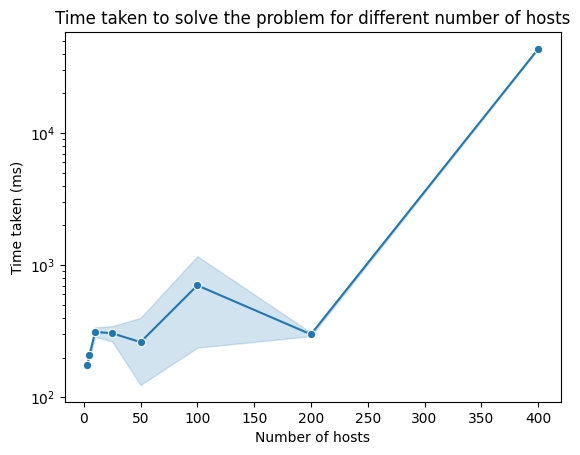

In [18]:
# plot the results of the experiment x axis would be the number of hosts and y axis would be the time taken to solve the problem

import matplotlib.pyplot as plt
import seaborn as sns
# have an exponential y axis
sns.lineplot(data=df, x='n_hosts', y='time_taken', marker='o')
plt.yscale('log')
plt.xlabel("Number of hosts")
plt.ylabel("Time taken (ms)")
plt.title("Time taken to solve the problem for different number of hosts")

plt.show()